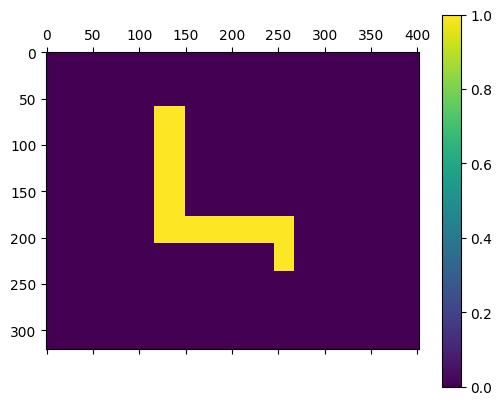

In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from PIL import Image
import random
import math
import time

from Point import Point

# Load the image and convert to grayscale
image_path = "../data/map5.png"
image = Image.open(image_path).convert("L")

# Convert image data to numpy array and normalize
grid_map = np.array(image.getdata()).reshape(image.size[1], image.size[0]) / 255

# Binarize the image: convert to binary values (0 for free space, 1 for obstacles)
threshold = 0.5  # Adjust threshold if needed
grid_map[grid_map > threshold] = 1
grid_map[grid_map <= threshold] = 0

# Invert colors to make 0 -> free and 1 -> occupied
grid_map = (grid_map * -1) + 1

q_start = Point(300, 300)
q_goal = Point(10,10)

# Build C space
C = []
for i, row in enumerate(grid_map):
    for j, cell in enumerate(row):
        if cell == 0:
            C.append([i, j])


# Visualize the grid map
plt.matshow(grid_map)
plt.colorbar()
plt.show()

In [2]:
def rand_config(grid_map, p, q_goal):
    if np.random.rand() < p:
        return q_goal
    else:
        x = np.random.uniform(0, grid_map.shape[0] - 1)
        y = np.random.uniform(0, grid_map.shape[1] - 1)
        return Point(x, y)


def nearest_vertex(q_rand, G):
    vertices = G["vertices"]
    smallest_distance = float('inf')
    nearest_vertex = None
    for vertex in vertices:
        #distance = euclidean_distance(q_rand, vertex)
        distance = q_rand.dist(vertex)
        if distance < smallest_distance:
            smallest_distance = distance
            nearest_vertex = vertex

    return nearest_vertex


def new_config(q_near, q_rand, delta_q):
    delta_x = q_rand.x - q_near.x
    delta_y = q_rand.y - q_near.y
    #distance = euclidean_distance(q_near, q_rand)
    distance = q_near.dist(q_rand)
    if distance == 0:
        return q_near

    direction = [delta_x/distance, delta_y/distance]
    move_x = direction[0] * delta_q
    move_y = direction[1] * delta_q

    new_x = round(q_near.x + move_x)
    new_y = round(q_near.y + move_y)
    q_new = Point(new_x, new_y)

    #if euclidean_distance(q_near, q_new) > distance:
    if q_near.dist(q_new) > distance:
        q_new = Point(q_rand.x, q_rand.y)

    return q_new

def is_segment_free_inc(q_near, q_new, C):
    num_samples = int(max(abs(q_new.x - q_near.x), abs(q_new.y - q_near.y)) + 1)
    x_coords = np.linspace(q_near.x, q_new.x, num_samples).astype(int)
    y_coords = np.linspace(q_near.y, q_new.y, num_samples).astype(int)

    for x, y in zip(x_coords, y_coords):
        if [x, y] not in C:  # Check if the point is not in the obstacle-free list
            #print(f"Collision detected at: ({x}, {y})")
            return False

    return True

def add_vertex(G, vertex):
    G["vertices"].append(vertex)

def add_edge(G, vertex_1, vertex_2):
    G["edges"].append((vertex_1, vertex_2))


In [3]:
def fill_path(vertices, edges, q_goal):
    if not edges:
        return vertices, edges, []
    path = []
    start_v= vertices[0]
    goal_v = None
    # Find the goal vertex
    for edge in edges:
        if edge[1] == q_goal:
            goal_v = q_goal
            break

    if goal_v is None:
        return vertices, edges, []  # goal not found

    parent = {edge[1]: edge[0] for edge in edges}
    current = goal_v
    while current != start_v:
        path.append(current)
        if current in parent:
            current = parent[current]
        else:
            return vertices, edges, []  # path is incomplete, exit early

    path.append(start_v)
    path.reverse()
    return vertices, edges, path

def path_distance(path):
    # Calculate path distance
    path_distance = 0
    for i in range(1, len(path)):
        path_distance = path_distance + path[i - 1].dist(path[i])
    path_distance = round(path_distance, 2)
    
    return path_distance

def plot_RRT_star(grid_map, vertices, edges, q_start, q_goal, path=None):
    plt.figure(figsize=(10, 10))
    plt.matshow(grid_map, fignum=0)

    for edge in edges:
        vertex_1, vertex_2 = edge
        x_coords = [vertex_1.y, vertex_2.y]
        y_coords = [vertex_1.x, vertex_2.x]
        plt.plot(x_coords, y_coords, 'w-')

    plt.plot(q_start.y, q_start.x, "r*")
    plt.plot(q_goal.y, q_goal.x, "g*")

    if path:
        for i in range(len(path) - 1):
            plt.plot([path[i].y, path[i + 1].y], [path[i].x, path[i + 1].x], color='red')

    plt.show()



In [ ]:
def RRT_star(grid_map, C, K, delta_q, p, q_start, q_goal, r):
    G = {
        "vertices": [q_start],
        "edges": []
    }

    cost = {q_start: 0}
    min_dist = 1
    initial_solution_found = False
    initial_solution_path = []

    for k in range(1, K):
        q_rand = rand_config(grid_map, p, q_goal)  # Random configuration
        q_near = nearest_vertex(q_rand, G)  # Find nearest vertex
        q_new = new_config(q_near, q_rand, delta_q)  # Generate new configuration

        if is_segment_free_inc(q_near, q_new, C):  # Check if the segment is free of obstacles
            neighbours = [v for v in G["vertices"] if v.dist(q_new) <= r]
            q_min = q_near
            cost[q_new] = float('inf')

            for n in neighbours:
                if is_segment_free_inc(n, q_new, C):
                    if cost[n] + n.dist(q_new) < cost[q_new]:
                        q_min = n
                        cost[q_new] = cost[n] + n.dist(q_new)

            add_vertex(G, q_new)
            add_edge(G, q_min, q_new)

            for n in neighbours:
                if is_segment_free_inc(n, q_new, C):
                    if cost[q_new] + q_new.dist(n) < cost[n]:
                        cost[n] = cost[q_new] + q_new.dist(n)
                        G["edges"] = [edge for edge in G["edges"] if edge[1] != n]
                        add_edge(G, q_new, n)

            # Once a valid path is found, plot it and continue expanding the tree
            if q_new.dist(q_goal) < min_dist:
                if is_segment_free_inc(q_new, q_goal, C):
                    add_vertex(G, q_goal)
                    add_edge(G, q_new, q_goal)
                    cost[q_goal] = cost[q_new] + q_new.dist(q_goal)

                    if not initial_solution_found:
                        initial_solution_found = True
                        _, _, initial_solution_path = fill_path(G["vertices"], G["edges"],q_goal)

                        # Plot initial solution path
                        initial_distance = path_distance(initial_solution_path)
                        plot_RRT_star(grid_map, G["vertices"], G["edges"], q_start, q_goal, initial_solution_path)
                        print(f"Initial path distance: {initial_distance}")
                        print("Initial path:")
                        print([(p.x, p.y) for p in initial_solution_path])
                        # Continue iterating to optimize the path

    # After K iterations, get the final path and plot the optimized solution path
    final_solution_path = []
    if q_goal in cost:
        _, _, final_solution_path = fill_path(G["vertices"], G["edges"], q_goal)

    return G, cost, initial_solution_path, final_solution_path

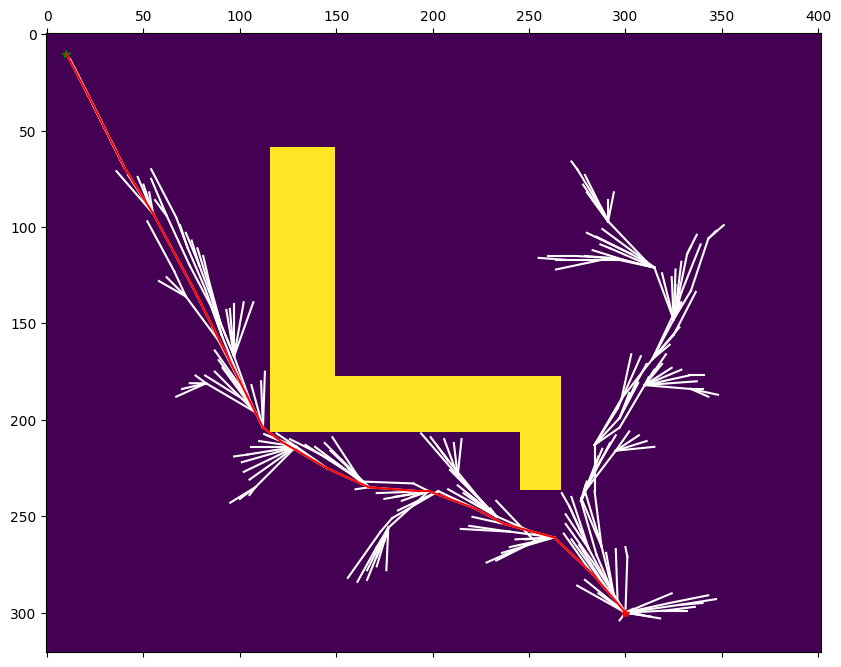

Initial path distance: 437.11
Initial path:
[(300, 300), (280, 283), (261, 263), (254, 237), (246, 222), (237, 198), (237, 193), (235, 167), (225, 145), (211, 121), (204, 112), (196, 108), (188, 104), (180, 100), (154, 87), (134, 77), (119, 69), (93, 55), (69, 40), (61, 36), (53, 32), (33, 22), (10, 10), (10, 10)]


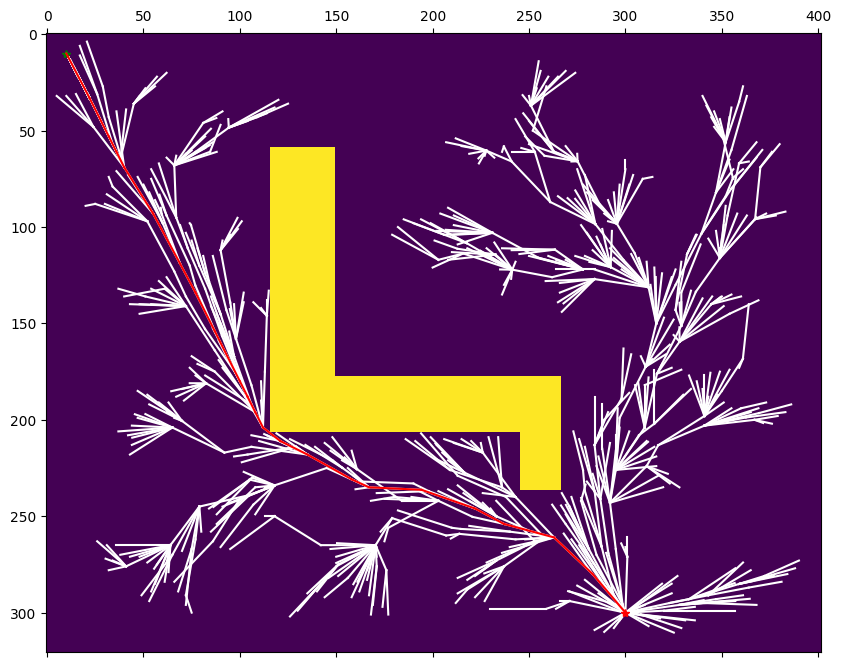

Final path distance: 437.03
Final path:
[(300, 300), (280, 283), (261, 263), (254, 237), (246, 222), (236.30497747244246, 194.232163853618), (235, 167), (230.92103800813777, 158.11395804532407), (218, 135), (211, 121), (204, 112), (196, 108), (188, 104), (180, 100), (154, 87), (134, 77), (119, 69), (93, 55), (69, 40), (61, 36), (53, 32), (33, 22), (10, 10), (10, 10)]


In [5]:

G, cost, initial_solution_path, final_solution_path = RRT_star(grid_map, C, 1000, 5, 0.2, q_start, q_goal, 30)
vertices = G["vertices"]
edges = G["edges"]

# Declare if no initial solution found
if not initial_solution_path:
    print("No initial solution found.")

# Visualize the final solution
if final_solution_path:
    final_distance = path_distance(final_solution_path)
    plot_RRT_star(grid_map, vertices, edges, q_start, q_goal, final_solution_path)
    print(f"Final path distance: {final_distance}")
    print("Final path:")
    print([(p.x, p.y) for p in final_solution_path])
else:
    print("No final solution found.")